In [79]:
import sys; sys.path.append('../../wwa'); from wwa import *

# silence warnings about large chunk sizes
import dask; dask.config.set(**{'array.slicing.split_large_chunks': False})

xn, xx, yn, yx = [-122,-80,10,36.5]
mapproj = cartopy.crs.PlateCarree()
sf = gpd.read_file("sf_cam-heatwave")

In [58]:
sites = ["Las Vegas, NV", "Phoenix, AZ", "Tabasco, MX", "Chihuahua, MX", "Coatzacoalcos, MX", "Valladolid, MX", "Aguascalientes", "Ciudad Victoria, MX",
         "Sombrerete", "Queretaro", "Veracruz, MX", "Baja California, MX", "Sonora, MX", "Mexico City, MX", "La Fragua, Guatemala"]
px = {s : get_latlon(s) for s in sites}
# px = {"Ciudad Victoria, MX" : {"lon" : -99.15, "lat" : 23.474}} 

In [3]:
sites_sam = ["San Jose de Chiquitos, Bolivia", "Puerto Suarez, Bolivia", "Buenos Aires, Argentina", "Puerto Casado, Paraguay", "San Pedro, Paraguay"]
px_sam = {s : get_latlon(s) for s in sites_sam}

# MSWX

## Annual data over wider region

In [2]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/mswx/"

In [3]:
varnm = "tmin"

y = 2024
da_past = xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/"+varnm+"_past/"+str(y)+"*.nc")
da_nrt = xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/"+varnm+"_nrt/"+str(y)+"*.nc")
da_nrt = da_nrt.sel(time = da_nrt.time > da_past.time.max())

da = wrap_lon(xr.concat([da_past, da_nrt], "time"))
da = da.sel(lon = slice(xn,xx), lat = slice(yn,yx)).air_temperature.rename(varnm)

rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(da.lon, da.lat)

da.where(rm == 0).to_netcdf(outpath+varnm+"_"+str(y)+".nc")

In [6]:
tmplt = xr.open_dataset(outpath+varnm"_2024.nc")
rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(tmplt.lon, tmplt.lat)

for y in range(1979, 2024):
    
    new_fnm = outpath+varnm"_"+str(y)+".nc"
    if os.path.exists(new_fnm): continue
    
    fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/"+varnm+"_past/"+str(y)+"*.nc"))
    da = wrap_lon(xr.open_mfdataset(fl))
    da = da.sel(lon = slice(xn,xx), lat = slice(yn,yx)).air_temperature.rename(varnm)
        
    da.where(rm == 0).to_netcdf(new_fnm)

## Compile

In [70]:
varnm = "tmin"
xr.open_mfdataset(sorted(glob.glob("/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/mswx/"+varnm+"_*"))).to_netcdf("data/"+varnm+"_mswx.nc")

# Nino time series

In [233]:
nino = xr.open_dataset("/rds/general/user/cb2714/home/wwa/10_misc/detrended_nino34/ersst_nino34_detrended.nc").nino34.rolling(time = 3, center = False).mean()
nino = merge_byindex([nino.groupby("time.month")[m].assign_coords(time = nino.groupby("time.month")[m].time.dt.year).rename(["djf","jfm","fma","mam"][m-2], time = "year").to_dataframe() for m in [2,3,4,5]])
nino = nino.dropna(axis = 0, how = "any")

In [235]:
nino.to_csv("data/nino_3monthly.csv")

# Identify impacted region

In [5]:
da = xr.open_dataset("/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/mswx/tmax_2024.nc").tmax.sel(time = slice("2024-05-29",None))

In [6]:
# da = xr.open_dataset("data/era5_tmax_daily_extended_-120--45E_-45-40N_su.nc").tmax.sel(time = slice("2024-05-29",None))

In [ ]:
da.plot(col = "time", col_wrap = 4, cmap = "YlOrRd", subplot_kws = {"projection" : mapproj}, cbar_kwargs = {"location" : "bottom", "pad" : 0.025, "fraction" : 0.025}, vmin = 30, vmax = 45)

for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    ax.scatter([v["lon"] for k,v in px.items()], [v["lat"] for k,v in px.items()], color = "darkred", marker = "x")
    ax.gridlines(color = "k", alpha = 0.1)

## Shapefile

In [174]:
df1 = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe()
df1 = df1.loc[[c in ["MX", "BZ", "GT", "HN", "SV"] for c in df1.abbrevs]]

In [175]:
df2 = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.to_geodataframe()
df2 = df2.loc[[s in ["AZ", "NV", "NM", "TX", "CA"] for s in df2.abbrevs]].clip((-125,-95,20,36.5))

In [181]:
df = pd.concat([df1, df2]).dissolve().explode(index_parts = False)
df = df.loc[df.geometry.area == df.geometry.area.max()].set_crs(mapproj)
df["geometry"] = [Polygon(g.exterior.coords) for g in df.geometry]

In [182]:
df.to_file("sf_cam-heatwave")

In [165]:
ar6 = regionmask.defined_regions.ar6.land.to_geodataframe().iloc[[6,7]]

## Event map

In [257]:
ndays = 5

In [258]:
# da_x = xr.open_dataset("/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/mswx/tmax_2024.nc").tmax.rolling(time = ndays).mean().sel(time = slice("2024-05", None))
da_x = xr.open_dataset("data/era5_tmax_daily_extended_-125--75E_9-37N_su.nc").tmax.rolling(time = ndays).mean().sel(time = slice("2024-05", None))

rm = regionmask.mask_geopandas(sf, da_x.lon, da_x.lat)
ts_x = da_x.where(rm == 0).mean(["lat", "lon"])

evx_end = ts_x.idxmax()
evx_start = evx_end - pd.to_timedelta(ndays-1, unit='d')
evx_range = " - ".join([str(d.dt.strftime("%d %b").values) for d in [evx_start, evx_end]])

evx = da_x.sel(time = evx_end)
evx = evx.where(evx > 0)

In [272]:
# da_n = xr.open_dataset("/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/mswx/tmin_2024.nc").tmin.rolling(time = ndays).mean().sel(time = slice("2024-05", None))
da_n = xr.open_dataset("data/era5_tmin_daily_extended_-125--75E_9-37N_su.nc").tmin.rolling(time = ndays).mean().sel(time = slice("2024-05", "2024-06-09"))

rm = regionmask.mask_geopandas(sf, da_n.lon, da_n.lat)
ts_n = da_n.where(rm == 0).mean(["lat", "lon"])

evn_end = ts_n.idxmax()
evn_start = evn_end - pd.to_timedelta(ndays-1, unit='d')
evn_range = " - ".join([str(d.dt.strftime("%d %b").values) for d in [evn_start, evn_end]])

evn = da_n.sel(time = evn_end)
evn = evn.where(evn > 0)

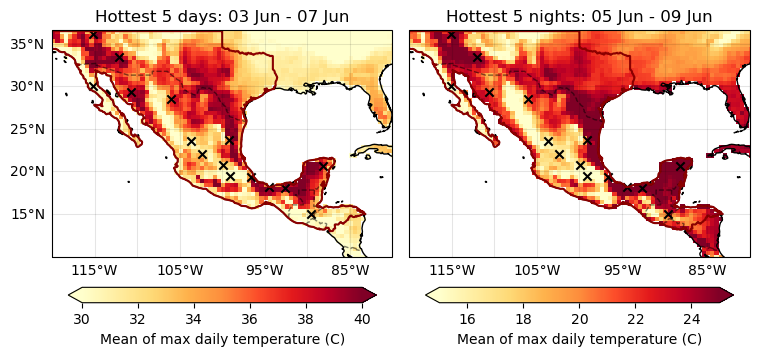

In [279]:
fig, axs = plt.subplots(ncols = 2, figsize = (9,4), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : (-120,-80,10,35)}, sharey = True, sharex = True)
plt.subplots_adjust(wspace = 0.05)

rm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(da_n.lon, da_n.lat)

ax = axs[0]
evx.where(rm == 0).plot(ax = ax, cmap = "YlOrRd", vmin = 30, vmax = 40, cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.1, "label" : "Mean of max daily temperature (C)"})
ax.set_title("Hottest 5 days: "+evx_range)

ax = axs[1]
evn.where(rm == 0).plot(ax = ax, cmap = "YlOrRd", vmin = 15, vmax = 25, cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.1, "label" : "Mean of max daily temperature (C)"})
ax.set_title("Hottest 5 nights: "+evn_range)

for ax in axs:
    sf.boundary.plot(ax = ax, color = "darkred")
    ax.scatter([v["lon"] for k,v in px.items()], [v["lat"] for k,v in px.items()], color = "k", marker = "x")
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = False)
    ax.gridlines(color = "k", alpha = 0, draw_labels = ["bottom"], xlocs = range(-125,-75,10))

axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"])

plt.savefig("fig/event-map-with-impacts_era5.png")

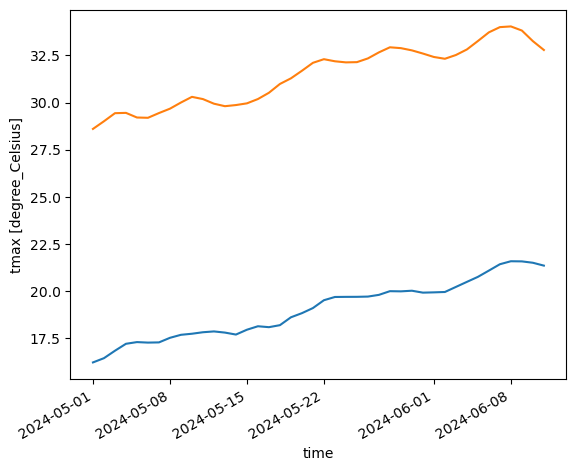

In [17]:
ts_n.plot()
ts_x.plot()

## Gridded seasonal cycle

In [5]:
da = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/mswx/*.nc").tmax)
# rm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(da.lon, da.lat)
rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
da = da.where(rm == 0).dropna("lon", "all").dropna("lat", "all").load()

In [ ]:
sc_by_lat = da.sel(time = slice("1990", "2020")).groupby_bins(group = "lat", bins = range(10,38)).mean().mean("lon").groupby("time.dayofyear").mean().dropna("lat_bins", "all")
sc_by_lon = da.sel(time = slice("1990", "2020")).groupby_bins(group = "lon", bins = range(-125,-80)).mean().mean("lat").groupby("time.dayofyear").mean().dropna("lon_bins", "all")

In [ ]:
d1 = da.sel(time = "2020-05-01").time.dt.dayofyear.values - 0.5
d2 = da.sel(time = "2020-06-30").time.dt.dayofyear.values + 0.5

fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, gridspec_kw = {"width_ratios" : [1,1,1]})

plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 5, "vmax" : 35, "add_colorbar" : False}

sc_by_lat.transpose().plot(ax = axs[0], **plot_kwargs) 
axs[0].set_ylabel("Latitude")
[axs[0].axvline(x, color = "k") for x in [d1, d2]]
axs[0].grid(color = "k", alpha = 0.2, axis = "y")

cbar = sc_by_lon.plot(ax = axs[1], **plot_kwargs) 
axs[1].set_xlabel("Longitude")
axs[1].grid(color = "k", alpha = 0.2, axis = "x")
[axs[1].axhline(x, color = "k") for x in [d1, d2]]

ax = axs[2]
# axs[2].set_axis_off()
# ax = fig.add_subplot(133, projection = mapproj)
da.sel(time = slice("1990", "2020")).rolling(time = 2).mean().mean("time").plot(ax = ax, **plot_kwargs)
axs[2].grid(color = "k", alpha = 0.2)
# ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
# ax.coastlines()
# ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.2, label = "Mean temperature (degC)")

plt.suptitle("Seasonal cycle of tmax at each latitude & longitude, annual climatology - MSWX (1990-2020)")
plt.savefig("fig/seasonal-cycle_latlon_tmax_mswx.png")

# ERA5

! cd data; wget https://climexp.knmi.nl/data/era5_tmax_daily_extended_-125--75E_9-37N_su.nc; wget https://climexp.knmi.nl/data/era5_tmin_daily_extended_-125--75E_9-37N_su.nc

## Gridded seasonal cycle

In [85]:
varnm = "tmin"
da = wrap_lon(xr.open_dataset("data/era5_"+varnm+"_daily_extended_-125--75E_9-37N_su.nc")[varnm]).assign_attrs(long_name = "Mean temperature")
# rm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(da.lon, da.lat)
rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
da = da.where(rm == 0).dropna("lon", "all").dropna("lat", "all")

# save daily time series for testing SC later on
da.mean(["lat", "lon"]).to_netcdf("data/"+varnm+"_daily-ts_era5.nc")

In [24]:
sc_by_lat = da.sel(time = slice("1990", "2020")).groupby_bins(group = "lat", bins = range(10,38)).mean().mean("lon").groupby("time.dayofyear").mean().dropna("lat_bins", "all")
sc_by_lon = da.sel(time = slice("1990", "2020")).groupby_bins(group = "lon", bins = range(-125,-80)).mean().mean("lat").groupby("time.dayofyear").mean().dropna("lon_bins", "all")

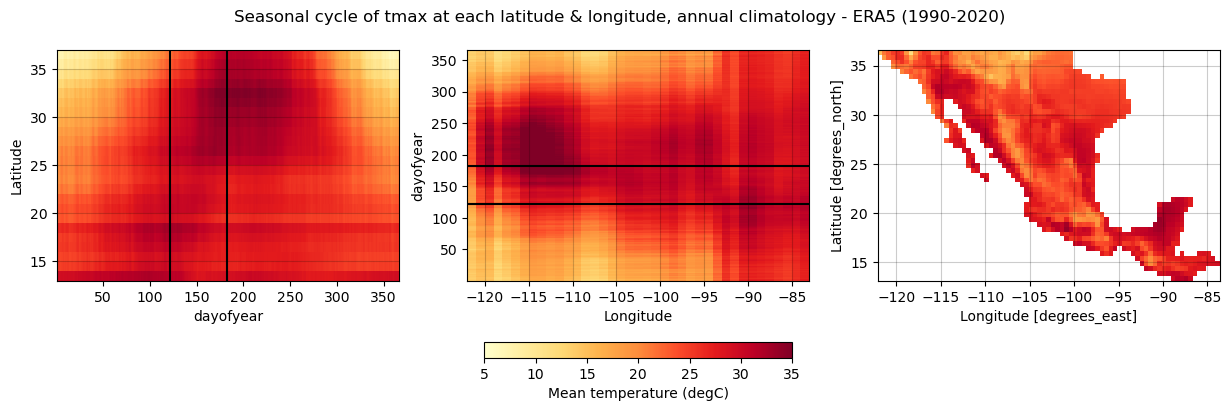

In [74]:
d1 = 121.5
d2 = 182.5

fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, gridspec_kw = {"width_ratios" : [1,1,1]})

plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 5, "vmax" : 35, "add_colorbar" : False}

sc_by_lat.transpose().plot(ax = axs[0], **plot_kwargs) 
axs[0].set_ylabel("Latitude")
[axs[0].axvline(x, color = "k") for x in [d1, d2]]
axs[0].grid(color = "k", alpha = 0.2, axis = "y")

cbar = sc_by_lon.plot(ax = axs[1], **plot_kwargs) 
axs[1].set_xlabel("Longitude")
axs[1].grid(color = "k", alpha = 0.2, axis = "x")
[axs[1].axhline(x, color = "k") for x in [d1, d2]]

ax = axs[2]
# axs[2].set_axis_off()
# ax = fig.add_subplot(133, projection = mapproj)
da.sel(time = slice("1990", "2020")).rolling(time = 2).mean().mean("time").plot(ax = ax, **plot_kwargs)
axs[2].grid(color = "k", alpha = 0.2)
# ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
# ax.coastlines()
# ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.2, label = "Mean temperature (degC)")

plt.suptitle("Seasonal cycle of "+varnm+" at each latitude & longitude, annual climatology - ERA5 (1990-2020)")
plt.savefig("fig/seasonal-cycle_latlon_"+varnm+"_era5.png")

# CORDEX

## Get spatial pattern, seasonal cycle & daily series

In [6]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CAM-*/*/*/*/"
outpath = "/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/cordex/"

In [25]:
for varnm in ["tasmax", "tasmin"]:
    
    print(varnm)
    ml = glob.glob(fpath+varnm+"/")

    for mpath in ml:

        mdl = "_".join(mpath.split("/")[-6:-2])
        print("  "+mdl)

        new_fnm = outpath+varnm+"_"+mdl+".nc"
        if os.path.exists(new_fnm): continue

        # list all valid files
        fl_hist = sorted(glob.glob(mpath+"*hist*.nc"))
        fl_fut = sorted(glob.glob(mpath+"*rcp*.nc"))
        
        if len(fl_hist) == 0 or len(fl_fut) == 0:
            print("    No files")
            continue

        # load all data
        da_hist = xr.open_mfdataset(fl_hist)
        da_fut = xr.open_mfdataset(fl_fut)

        if da_fut.time[0] <= da_hist.time[-1]: da_fut = da_fut.sel(time = da_fut.time > da_hist.time[-1])

        da = wrap_lon(xr.concat([da_hist, da_fut], "time"))[varnm]
        if "height" in da.coords: da = da.reset_coords("height", drop = True)

        # specify x & y dims
        if "rlon" in da.dims:
            xdim, ydim = ["rlon", "rlat"]
        elif "x" in da.dims:
            xdim, ydim = ["x", "y"]
        else:
            print("Unknown dims: ", da.dims)
            continue

        # select wider area for spatial pattern, load data
        box = np.logical_and(np.logical_and(da.lon >= xn, da.lon <= xx), np.logical_and(da.lat >= yn, da.lat <= yx))
        box = box.where(box == 1).dropna(xdim, "all").dropna(ydim, "all")

        da = convert_units_to(da.sel({xdim : box[xdim], ydim : box[ydim]}).load(), "degC")

        # spatial pattern
        sp = da.resample(time = "MS").mean().rolling(time = 2).mean().groupby("time.month")[6].sel(time = slice("1990","2020")).mean("time")
        sp.to_netcdf(outpath+varnm+"-spatial_"+mdl+".nc")

        # daily time series
        rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
        ts = da.where(rm == 0).mean([xdim, ydim])
        ts.to_netcdf(outpath+varnm+"_"+mdl+".nc")

        # seasonal cycle over whole region
        sc = ts.sel(time = slice("1991","2020")).groupby("time.dayofyear").mean()
        sc.to_netcdf(outpath+varnm+"-sc_"+mdl+".nc")
        
clear_output(wait = False)
print("Done.")

Done.


## Time series for climate explorer 

In [46]:
for varnm in ["tasmax", "tasmin"]:

    fl = glob.glob("/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/cordex/"+varnm+"_*.nc")
    vnm = "t"+varnm[-1]+"5x"
    long_name = {"tx5x" : "maximum", "tn5x" : "minimum"}[vnm]
    
    for fnm in fl:
        
        da = xr.open_dataset(fnm)[varnm]
        ts = da.rolling(time = 5).mean().sel(time = [m in [5,6] for m in da.time.dt.month]).resample(time = "AS-JAN").max()
        ts = ts.assign_coords(time = ts.time.dt.year).to_dataframe()
        
        mdl = re.sub(".nc", "", "_".join(fnm.split("_")[-4:]))
        
        csv_fnm = "Americas-heatwave_"+vnm+"_"+mdl
        
        csv_fullpath = "ts_cordex/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
            
        # create extra header lines for upload to Climate Explorer 
        str1 = "# contact :: CORDEX "+mdl+" - "+vnm.upper()+" during May-June over central America & southern US - Americas heatwave 2024, c.barnes22@imperial.ac.uk"
        str2 = "# "+vnm+" [degC] May-June maximum of 5-day running mean of daily "+long_name+" temperatures at "+csv_fnm+".dat"
        head = "# year degC"
        
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

        clear_output(wait = False)

# HighResMIP

## Get spatial pattern, seasonal cycle & daily series

In [4]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/highresmip/"
outpath = "/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/highresmip/"

In [ ]:
for varnm in ["tasmax", "tasmin"]:
    
    print(varnm)
    ml = glob.glob(fpath+"*/"+varnm+"/")
    
    for mpath in ml:

        mdl = mpath.split("/")[-3]+"_r1i1p1f1"
        print("  "+mdl)
        
        new_fnm = outpath+varnm+"_"+mdl+".nc"
        if os.path.exists(new_fnm): continue
            
        # list all valid files
        fl_hist = sorted(glob.glob(mpath+"*present*.nc"))
        fl_fut = sorted(glob.glob(mpath+"*future*.nc"))
        
        if len(fl_hist) == 0 or len(fl_fut) == 0:
            print("    No files")
            continue
            
        # load all data
        da_hist = xr.open_mfdataset(fl_hist)
        da_fut = xr.open_mfdataset(fl_fut)

        if da_fut.time[0] <= da_hist.time[-1]: da_fut = da_fut.sel(time = da_fut.time > da_hist.time[-1])

        da = convert_units_to(wrap_lon(xr.concat([da_hist, da_fut], "time"))[varnm].sel(lon = slice(xn,xx), lat = slice(yn,yx)), "degC")
        
        if "height" in da.coords: da = da.reset_coords("height", drop = True)
            
        # spatial pattern
        sp = da.resample(time = "MS").mean().rolling(time = 2).mean().groupby("time.month")[6].sel(time = slice("1990","2020")).mean("time")
        sp.to_netcdf(outpath+varnm+"-spatial_"+mdl+".nc")
        
        # daily time series
        rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
        ts = da.where(rm == 0).mean(["lon", "lat"])
        ts.to_netcdf(outpath+varnm+"_"+mdl+".nc")
        
        # seasonal cycle over whole shapefile
        sc = ts.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
        sc.to_netcdf(outpath+varnm+"-sc_"+mdl+".nc")
        
clear_output(wait = False)
print("Done.")

tasmax
  EC-Earth3P_r1i1p1f1


## Time series for climate explorer 

In [7]:
for varnm in ["tasmax", "tasmin"]:

    fl = glob.glob("/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/highresmip/"+varnm+"_*.nc")
    vnm = "t"+varnm[-1]+"5x"
    long_name = {"tx5x" : "maximum", "tn5x" : "minimum"}[vnm]
    
    for fnm in fl:
        
        da = xr.open_dataset(fnm)[varnm]
        ts = da.rolling(time = 5).mean().sel(time = [m in [5,6] for m in da.time.dt.month]).resample(time = "AS-JAN").max()
        ts = ts.assign_coords(time = ts.time.dt.year).to_dataframe()

        mdl = fnm.split("_")[-2]
        
        csv_fnm = "Americas-heatwave_"+vnm+"_"+mdl
        
        csv_fullpath = "ts_highresmip/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
            
        # create extra header lines for upload to Climate Explorer 
        str1 = "# contact :: HighResMIP "+mdl+" - "+vnm.upper()+" during May-June over central America & southern US - Americas heatwave 2024, c.barnes22@imperial.ac.uk"
        str2 = "# "+vnm+" [degC] May-June maximum of 5-day running mean of daily "+long_name+" temperatures at "+csv_fnm+".dat"
        head = "# year degC"
        
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

        clear_output(wait = False)

---
# Obs time series for climate explorer

In [27]:
fl = glob.glob("data/*May-June*.nc")
for fnm in fl:
    
    ds = fnm.split("_")[2]
    varnm = "t"+fnm.split("_")[0][6]+"5x"
    long_name = {"tx5x" : "maximum", "tn5x" : "minimum"}[varnm]
    
    ts = xr.open_dataset(fnm)
    ts = ts.assign_coords(time = ts.time.dt.year).to_dataframe()
    
    csv_fnm = "Americas-heatwave_"+varnm+"_"+ds
    
    csv_fullpath = "ts_obs/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+varnm.upper()+" during May-June over central America & southern US - Americas heatwave 2024, c.barnes22@imperial.ac.uk"
    str2 = "# "+varnm+" [degC] May-June maximum of 5-day running mean of daily "+long_name+" temperatures at "+csv_fnm+".dat"
    head = "# year degC"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

---
# Graphics for comms

In [35]:
da = wrap_lon(xr.open_dataset("data/era5_tmax_daily_extended_-125--75E_9-37N_su.nc").tmax).assign_attrs(long_name = "Mean temperature")
rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
ts = da.where(rm == 0).mean(["lat", "lon"])

quantiles = ts.sel(time = slice("1990", "2020")).quantile([0.85, 0.9, 0.95, 0.99])
tx5x = ts.rolling(time = 5).mean().sel(time = [m in [5,6] for m in ts.time.dt.month]).resample(time = "AS-JAN").max()

In [ ]:
cm = matplotlib.cm.get_cmap('YlOrRd')

plt.bar(x = tx5x.time.dt.year, height = tx5x, color = cm(0))
plt.ylim(30,None)

for i in range(len(quantiles)):
    plt.bar(x = tx5x.time.dt.year, height = tx5x.where(tx5x >= quantiles[i]), color = cm((1/len(quantiles))*i))

# [plt.axhline(y, color = "k") for y in quantiles]

In [104]:
# GHCN-D station data saved as text file
ts = pd.read_csv("data/MXM00076491-CIUDAD_VICTORIA.txt", comment = "#", sep = " +", engine = "python", header = None, parse_dates = [[0,1,2]], index_col = 0)
quantiles = ts.loc[slice("1990","2020")].quantile([0.85, 0.9, 0.95, 0.99])
tx5x = ts.rolling(5).mean().loc[[m in [5,6] for m in ts.index.month]].resample("AS").max()

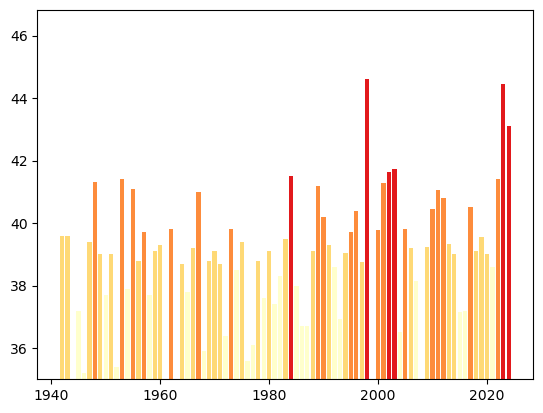

In [119]:
cm = matplotlib.cm.get_cmap('YlOrRd')

plt.bar(x = tx5x.index.year, height = tx5x[3], color = cm(0))
plt.ylim(35,None)

for i in range(len(quantiles)):
    plt.bar(x = tx5x.index.year, height = tx5x[3].where(tx5x[3] >= quantiles.iloc[i,0]), color = cm((1/len(quantiles))*i))

# Validation against station data

In [196]:
era5 = wrap_lon(xr.open_dataset("data/era5_tmax_daily_extended_-125--75E_9-37N_su.nc").tmax).rename("ERA5")
mswx = wrap_lon(xr.open_dataset("data/tmax_mswx.nc").tmax).rename("MSWX")

era5, mswx = [da.rolling(time = 5).mean().sel(time = [m in [5,6] for m in da.time.dt.month]).resample(time = "AS").max() for da in [era5, mswx]]

In [190]:
def read_ghcnd(fnm):
    
    # load data
    ts = pd.read_csv(fnm, comment = "#", sep = " +", engine = "python", header = None, parse_dates = [[0,1,2]], index_col = 0).rename(columns = {3 : "GHCN-D station"})
    
    # get tx5x
    tx5x = ts.rolling(5).mean().loc[[m in [5,6] for m in ts.index.month]].resample("AS").max()
    
    # get location & name metadata
    file = open(fnm, "r"); md = file.readlines()[1].split(); file.close()
    
    stn_lat = float(md[2][:-2])
    stn_lon = float(md[3][:-2])
    stn = md[9]
    
    era5_ts, mswx_ts = [da.sel(lon = stn_lon, lat = stn_lat, method = "nearest").reset_coords(drop = True).to_dataframe() for da in [era5, mswx]]
    
    df = merge_byindex([tx5x, era5_ts, mswx_ts])
    
    return df

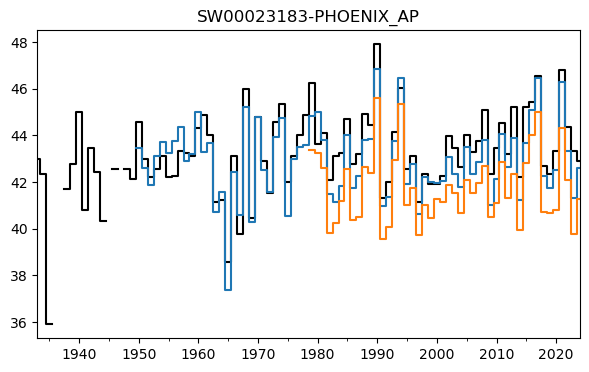

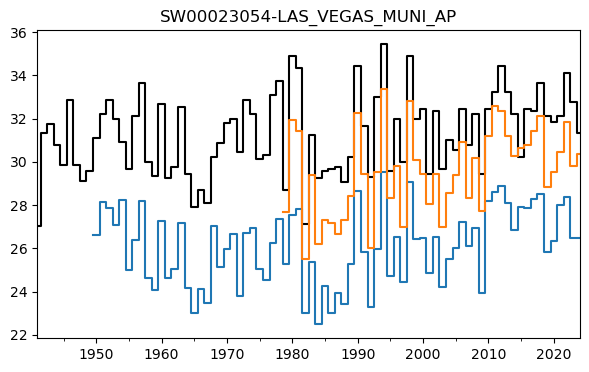

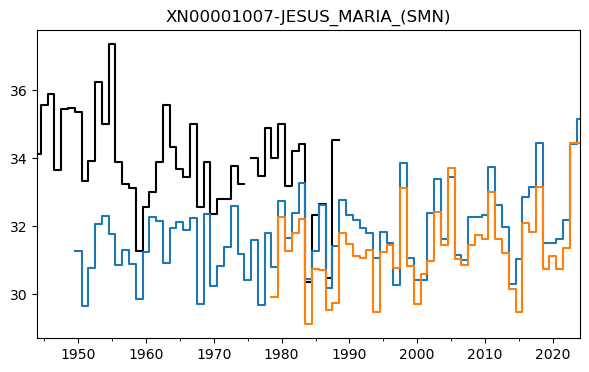

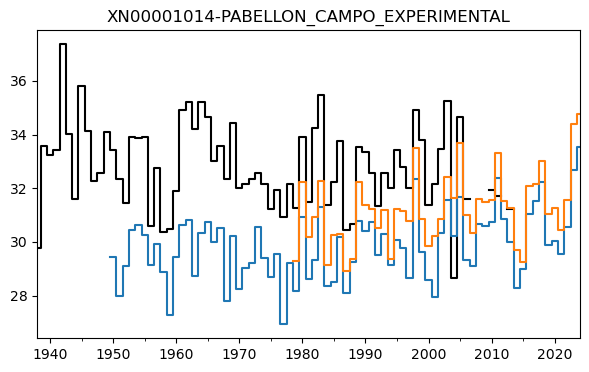

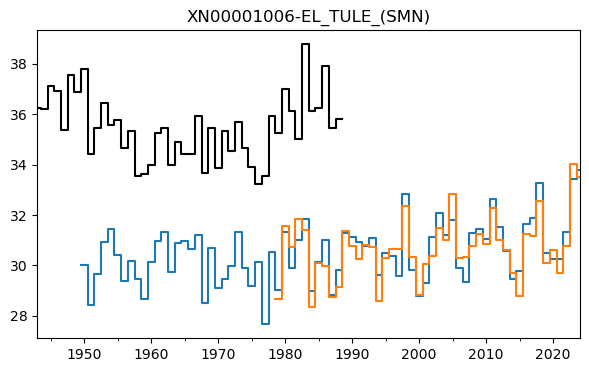

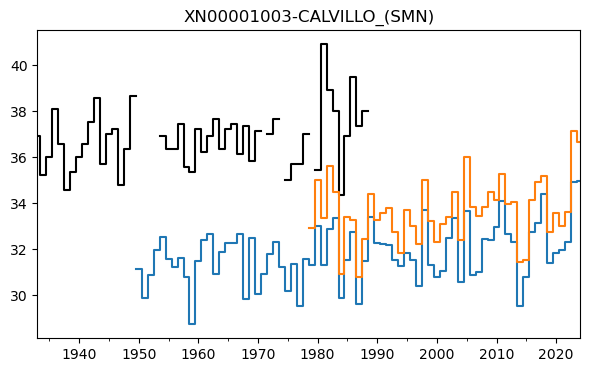

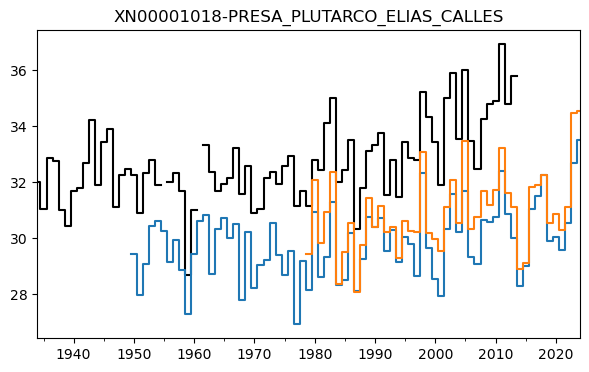

In [239]:
for fnm in glob.glob("data/USW*.txt") + glob.glob("data/MXN*.txt"):
    
    df = read_ghcnd(fnm)

    df.plot(drawstyle = "steps-mid", color = ["black", "tab:blue", "tab:orange"], figsize = (7,4), legend = False)
    plt.title(fnm[6:-4])
    plt.savefig("fig/stn-validation_"+fnm[6:-4]+".png")

# Flatten data for trend fitting

In [261]:
varnm = "tmin"
vnm = "t"+varnm[-1]+"5x"

tx = xr.open_dataset("data/era5_"+varnm+"_daily_extended_-125--75E_9-37N_su.nc")[varnm]
tx5x = tx.rolling(time = 5).mean().sel(time = [m in [5,6] for m in tx.time.dt.month]).resample(time = "AS").max()
tx5x = tx5x.assign_coords(time = tx5x.time.dt.year).rename(time = "year")

rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(tx5x.lon, tx5x.lat)
tx5x = tx5x.where(rm == 0)


In [262]:
# save the map for easier reconstruction later
tx5x.mean("year").to_netcdf("data/map-tmplt_"+vnm+"-era5.nc")

In [263]:
# flatten & save as .csv for transfer to R
da_df = tx5x.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas()

if da_df.shape[1] > 2500:
    for i in range(int(np.ceil(da_df.shape[1] / 2500))):
        da_df.iloc[:,slice(i*2500,(i+1)*2500)].to_csv("data/flattened/"+vnm+"-flattened_era5_"+str(i+1).rjust(2,"0")+".csv")
else:
    da_df.to_csv("data/flattened/"+vnm+"-flattened_era5.csv")

## Reshape dataframe into maps

In [264]:
warnings.filterwarnings("ignore", category = FutureWarning) # otherwise there will be a LOT of warnings

def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [279]:
varnm = "tmin"
vnm = "t"+varnm[-1]+"5x"
ds = "era5"

new_fnm = "data/res-gridded_"+vnm+"_"+ds+".nc"

# load map to be used to reshape
tmplt = xr.open_dataset("data/map-tmplt_"+vnm+"-"+ds+".nc")[varnm]

df = merge_byindex([pd.read_csv(fnm, index_col = 0) for fnm in sorted(glob.glob("data/gridded-res/"+vnm+"_gridded-res_"+ds+".csv"))])
mdl_res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])
mdl_res.to_netcdf(new_fnm)

## Plot maps

In [76]:
varnm = "tn5x"
ts = {"tx5x" : "day", "tn5x" : "night"}[varnm]

# load results of model fitted to gridded data
res = xr.open_dataset("data/res-gridded_"+varnm+"_era5.nc")

# replace infinite values with very high value
res["PR"] = res.PR.where(np.isfinite(res.PR), 100).where(~np.isnan(res.PR))

In [77]:
plot_kwargs = {"tx5x" : {
               "event_magnitude" : {"cmap" : "YlOrRd", "vmin" : 30, "vmax" : 45},
               "return_period"   : {"cmap" : "viridis", "norm" : matplotlib.colors.LogNorm(vmin = 1, vmax = 1000)},
               "PR"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 10},
               "dI_abs" : {"cmap" : "RdBu_r", "vmin" : -2, "vmax" : 2},
              },
               "tn5x" : {
               "event_magnitude" : {"cmap" : "YlOrRd", "vmin" : 20, "vmax" : 30},
               "return_period"   : {"cmap" : "viridis", "norm" : matplotlib.colors.LogNorm(vmin = 1, vmax = 1000)},
               "PR"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 10},
               "dI_abs" : {"cmap" : "RdBu_r", "vmin" : -2, "vmax" : 2},
              }}

main = {
        "alpha_gmst" : "Change in "+varnm+" (°C) per 1C increase in GMST",
        "dI_abs" : "Change in "+varnm.upper()+"\ndue to 1.2C increase in GMST",
        "event_magnitude" : "Hottest 5-"+ts+" period\nduring May-June 2024",
        "PR" : "Change in likelihood\ndue to 1.2C increase in GMST",
        "return_period" : "Return period of\nhottest 5-"+ts+" period",
       }

cbar_details = {
         "alpha_gmst" : {"label" : "Change in temperature (°C)", "extend" : "both"},
         "dI_abs" : {"label" : "Change in temperature (°C)", "extend" : "both"},
         "event_magnitude" : {"label" : "Temperature (°C)", "extend" : "both"},
         "PR" : {"label" : "Probability ratio", "extend" : "max"},
         "return_period" : {"label" : "Return period (years)", "extend" : "max", "format" : lambda x, pos: str(int(x))},
        }

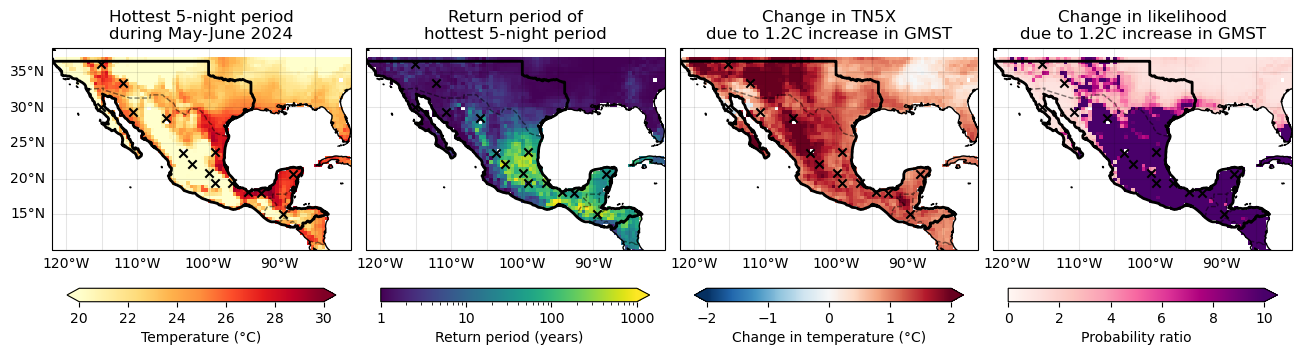

In [78]:
fig, axs = plt.subplots(ncols = 4, figsize = (16,5), dpi = 100, subplot_kw={"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.05)

cbar_kwargs = {"location" : "bottom", "fraction" : 0.065, "shrink" : 0.9, "pad" : 0.1, "extend" : "both"}

plot_vars = ["event_magnitude", "return_period", "dI_abs", "PR"]

for i in range(4):
    
    ax = axs[i]
    pv = plot_vars[i]
    
    res[pv].plot(ax = ax, **plot_kwargs[varnm][pv], cbar_kwargs = cbar_kwargs | cbar_details[pv])
    ax.scatter([v["lon"] for k,v in px.items()], [v["lat"] for k,v in px.items()], color = "k", marker = "x")
    
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    ax.set_title(main[pv])
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(-120,-80,5), draw_labels = ["bottom"])
    
axs[0].gridlines(alpha = 0, draw_labels = ["left"])

plt.savefig("fig/fitted-models-gridded_"+varnm+"_era5.png")

# Synthesis plots

In [202]:
def synth_plot(df, ax = None, logged = False):
    
    if not ax: fig, ax = plt.subplots(dpi = 100)
    
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta"}
    
    for k in range(len(df)):

        r = df.iloc[k]
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[r.name], alpha = 0.5 + 0.5*("synth" in r.name)))
        ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "none", lw = 1.5))

        ax.plot(r.est, -k, color = "k", marker = "v")  

    ax.set_yticks(range(0, -len(df), -1))
    ax.set_yticklabels(df.model)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k", zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", zorder = -99)

In [254]:
varnm = "tx5x"

In [255]:
synth = {a.lower()+"_"+b.lower() : pd.read_csv("synthesis/synth_"+a+"_"+b+"_"+varnm+".csv", index_col = "group") for a in ["dI","PR"] for b in ["attr","proj"]}

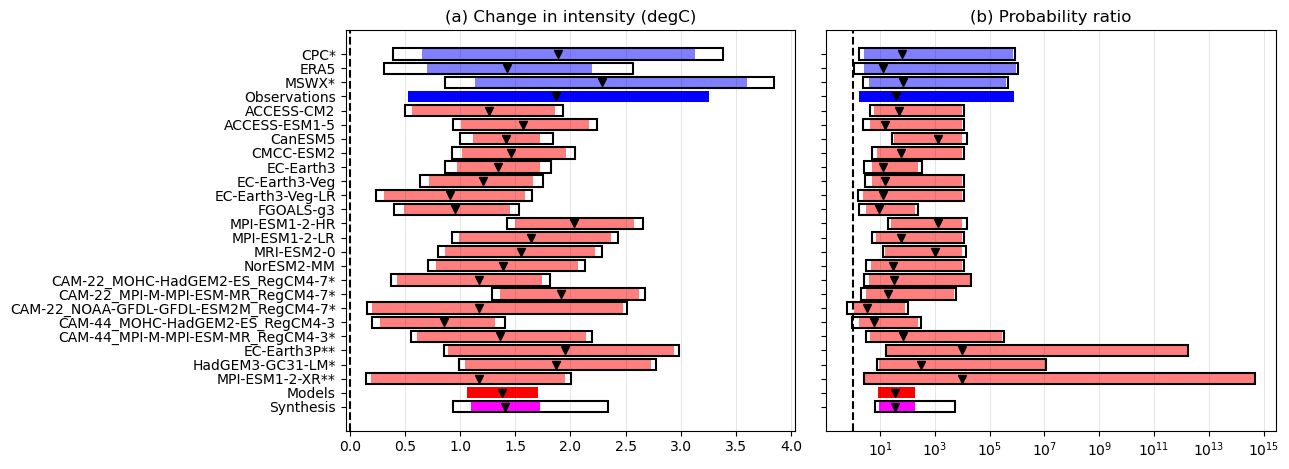

In [256]:
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (12,len(synth["di_attr"])*0.2))
plt.subplots_adjust(wspace = 0.07)

synth_plot(synth["di_attr"], ax = axs[0])
axs[0].set_title("(a) Change in intensity (degC)")
synth_plot(synth["pr_attr"], ax = axs[1], logged = True)
axs[1].set_title("(b) Probability ratio")

for ax in axs:
    ax.grid(axis = "x", color = "k", alpha = 0.1)
    
plt.savefig("fig/synthesis_"+varnm+"_attr.png")

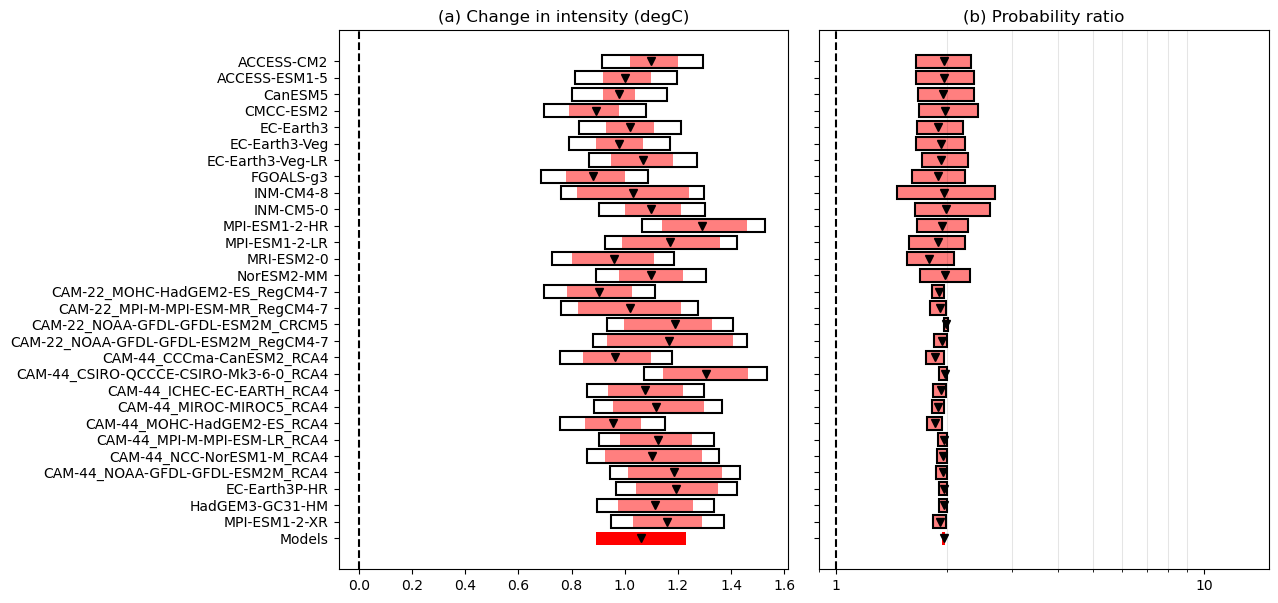

In [252]:
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (12,len(synth["di_attr"])*0.2))
plt.subplots_adjust(wspace = 0.07)

synth_plot(synth["di_proj"], ax = axs[0])
axs[0].set_title("(a) Change in intensity (degC)")
synth_plot(synth["pr_proj"], ax = axs[1], logged = True)
axs[1].set_title("(b) Probability ratio")
axs[1].set_xlim(0.9,15)
axs[1].xaxis.set_major_formatter(lambda x, pos: str(int(x)))
# axs[1].xaxis.set_minor_formatter(lambda x, pos: str(int(x)))

for ax in axs:
    ax.grid(axis = "x", which = "minor", color = "k", alpha = 0.1)

plt.savefig("fig/synthesis_"+varnm+"_proj.png")

## CORDEX

### Seasonal cycle

In [126]:
varnm = "tasmin"

vnm = varnm[0] + varnm[-3:]
era5 = xr.open_dataset("data/"+vnm+"_daily-ts_era5.nc")[vnm]
era5 = era5.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()

In [127]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/cordex/"
fl = sorted(glob.glob(outpath+varnm+"-sc_*.nc"))

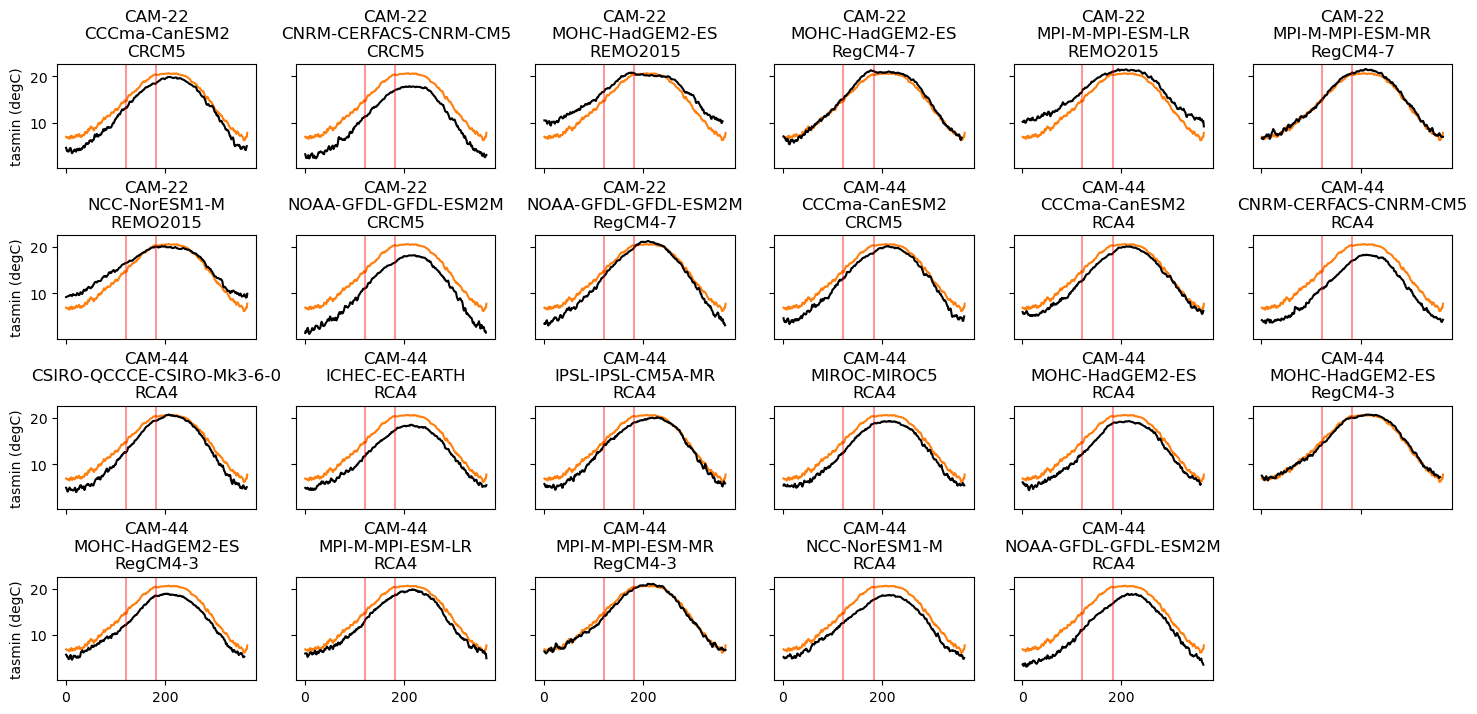

In [128]:
nc = 6; nr = 4

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 3, nr * 2), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.65)

for i in range(len(fl)):
    ax = fig.axes[i]
    
    era5.plot(ax = ax, color = "tab:orange")
    
    sc = convert_units_to(xr.open_dataset(fl[i])[varnm], "degC")
    sc.plot(ax = ax, color = "k")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("\n".join(fl[i].split("_")[2:4])+"\n"+re.sub(".nc","",fl[i].split("_")[5]))
    
    [ax.axvline(x, color = "red", alpha = 0.4) for x in [121.5, 182.5]]
    
for ax in axs[:,0]: ax.set_ylabel(varnm+" (degC)")
if nc * nr > len(fl):
    for j in range(len(fl), nc * nr): fig.axes[j].set_axis_off()
        
plt.savefig("fig/model-eval_"+varnm+"_cordex_seasonal-cycle_plots.png")

## Spatial pattern

In [161]:
varnm = "tasmin"

vnm = varnm[0] + varnm[-3:]
era5 = xr.open_dataset("data/era5_"+vnm+"_daily_extended_-125--75E_9-37N_su.nc")[vnm]
era5 = era5.sel(time = slice("1990","2020")).resample(time = "MS").mean().rolling(time = 2).mean().groupby("time.month")[6].mean("time")

In [162]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/cordex/"
fl = sorted(glob.glob(outpath+varnm+"-spatial_*.nc"))

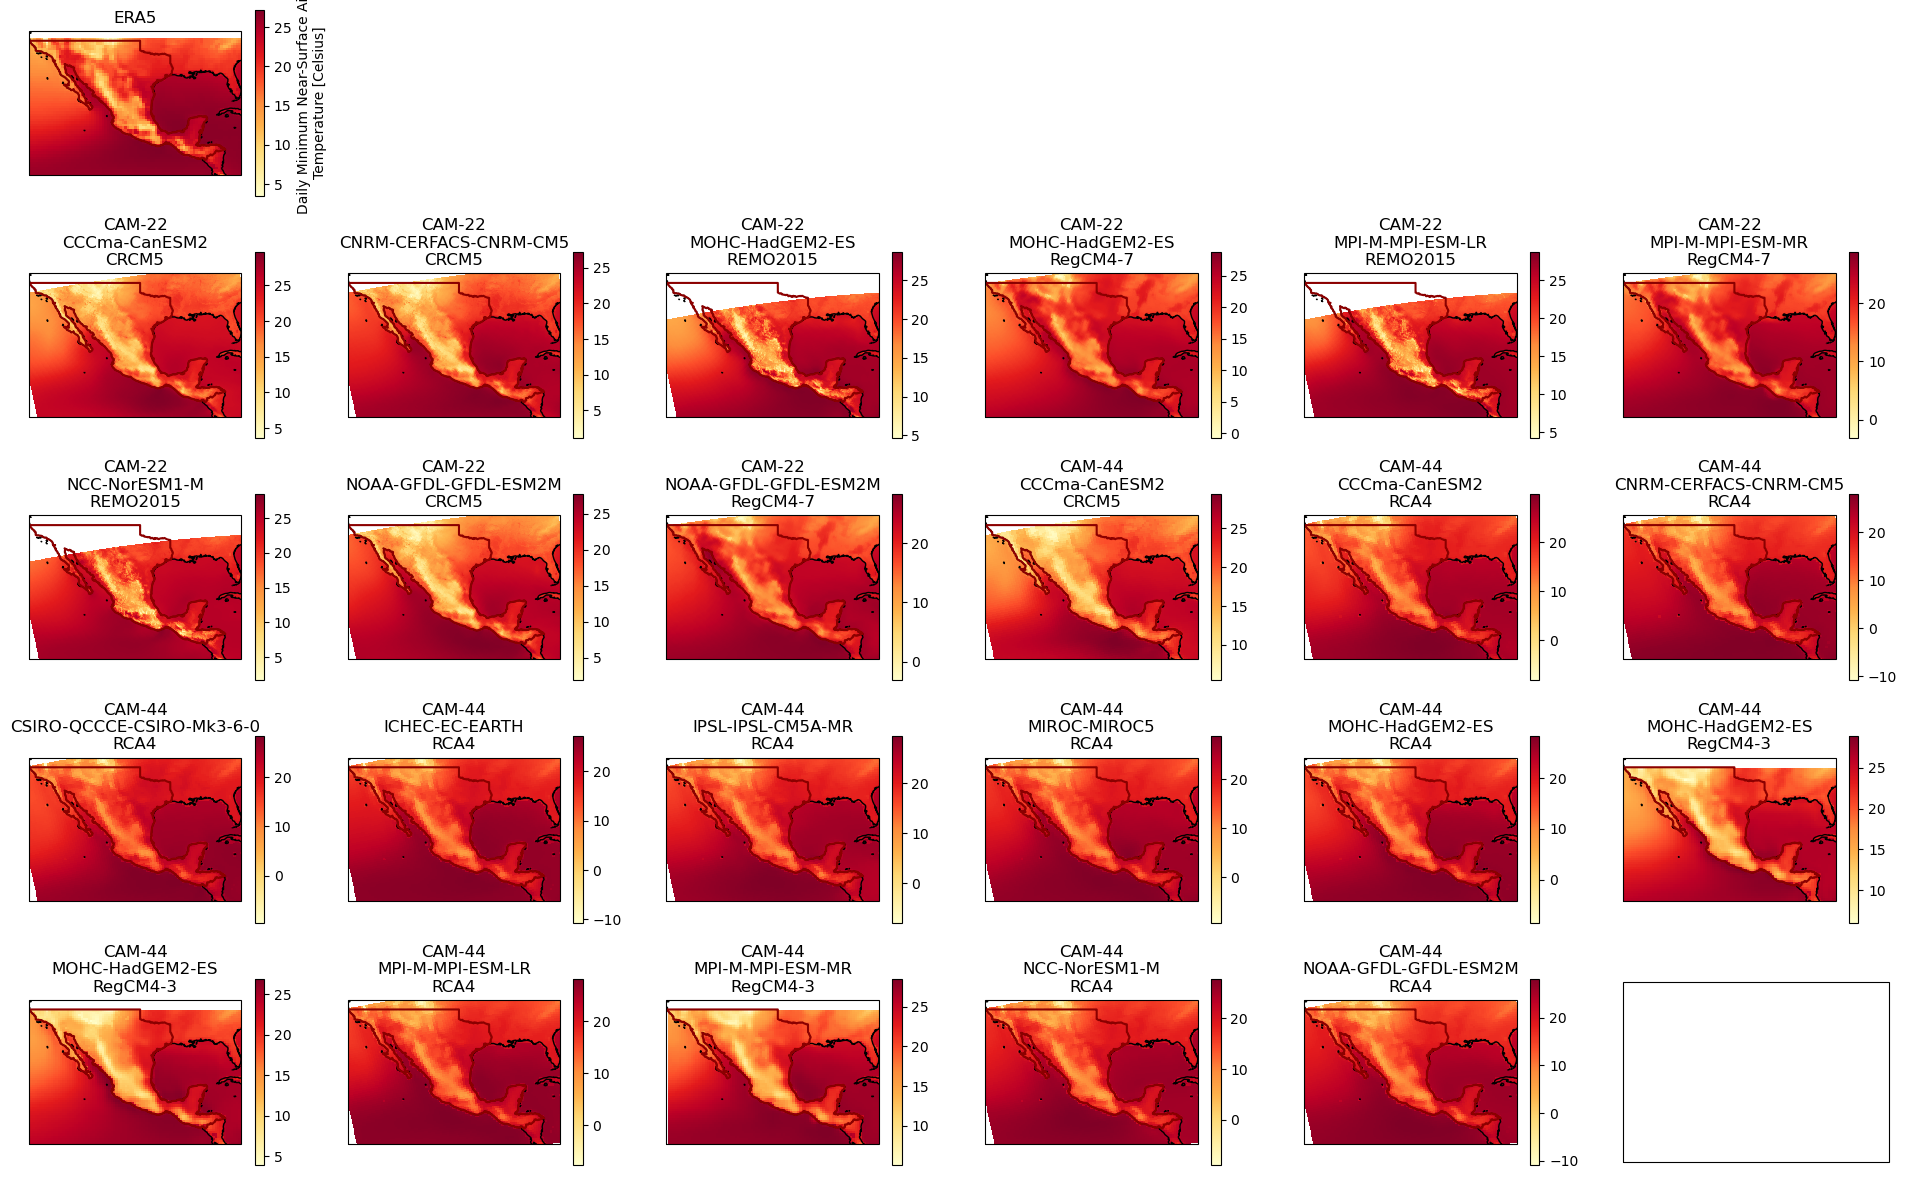

In [163]:
nc = 6; nr = 4

fig, axs = plt.subplots(ncols = nc, nrows = nr+1, figsize = (nc * 4, (nr+1) * 3), dpi = 100, sharex = True, sharey = True, 
                        subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(hspace = 0.3)

plot_kwargs = {"cmap" : "YlOrRd"}

ax = axs[0,0]
era5.plot(ax = ax, **plot_kwargs)
ax.set_title("ERA5")
ax.coastlines()
sf.boundary.plot(ax = ax, color = "darkred")

for ax in axs[0,1:]: ax.set_axis_off()

for i in range(len(fl)):
    ax = fig.axes[nc+i]

    sp = convert_units_to(xr.open_dataset(fl[i])[varnm], "degC")
    cbar = ax.pcolormesh(sp.lon, sp.lat, sp, **plot_kwargs)
#     ax.set_xlabel("")
#     ax.set_ylabel("")
    ax.set_title("\n".join(fl[i].split("_")[2:4])+"\n"+re.sub(".nc","",fl[i].split("_")[5]))
    plt.colorbar(cbar, ax = ax, location = "right")
    
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
        
if nc * nr > len(fl):
    for j in range(len(fl)+nc, (nr) * nc): fig.axes[j].set_axis_off()
        
plt.savefig("fig/model-eval_"+varnm+"_cordex_spatial-pattern_plots.png")

## HighResMIP

### Seasonal cycle

In [171]:
varnm = "tasmax"

vnm = varnm[0] + varnm[-3:]
era5 = xr.open_dataset("data/"+vnm+"_daily-ts_era5.nc")[vnm]
era5 = era5.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()

In [172]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/highresmip/"
fl = sorted(glob.glob(outpath+varnm+"-sc_*.nc"))

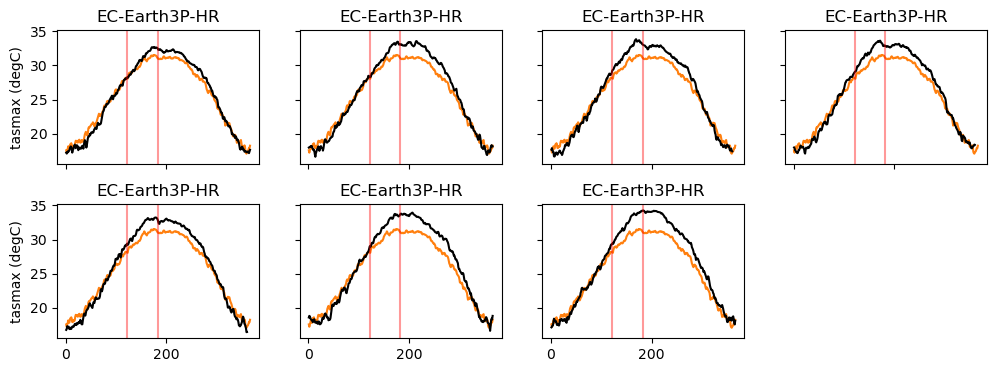

In [173]:
nc = 4; nr = 2

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 3, nr * 2), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    ax = fig.axes[i]
    
    era5.plot(ax = ax, color = "tab:orange")
    
    sc = convert_units_to(xr.open_dataset(fl[i])[varnm], "degC")
    sc.plot(ax = ax, color = "k")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(fl[0].split("_")[-2])
    
    [ax.axvline(x, color = "red", alpha = 0.4) for x in [121.5, 182.5]]
    
for ax in axs[:,0]: ax.set_ylabel(varnm+" (degC)")
if nc * nr > len(fl):
    for j in range(len(fl), nc * nr): fig.axes[j].set_axis_off()
        
plt.savefig("fig/model-eval_"+varnm+"_highresmip_seasonal-cycle_plots.png")

## Spatial pattern

In [180]:
varnm = "tasmax"

vnm = varnm[0] + varnm[-3:]
era5 = xr.open_dataset("data/era5_"+vnm+"_daily_extended_-125--75E_9-37N_su.nc")[vnm]
era5 = era5.sel(time = slice("1990","2020")).resample(time = "MS").mean().rolling(time = 2).mean().groupby("time.month")[6].mean("time")

In [181]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/cam-heatwave/highresmip/"
fl = sorted(glob.glob(outpath+varnm+"-spatial_*.nc"))

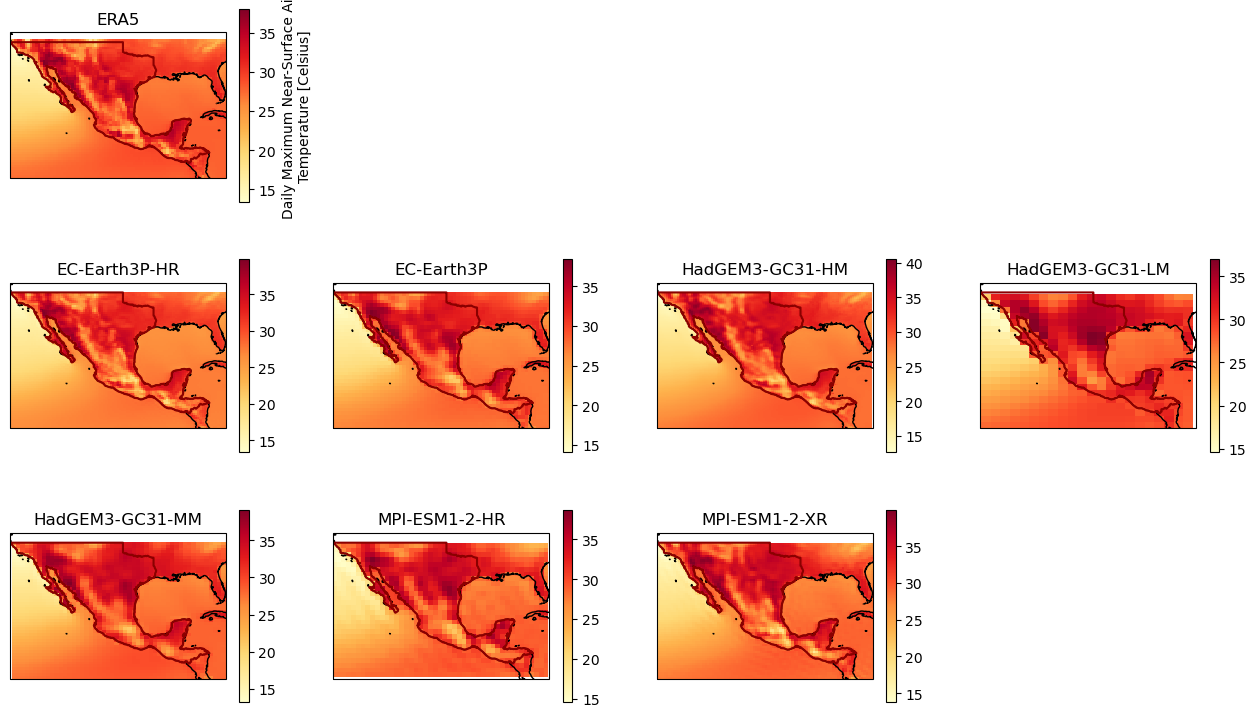

In [182]:
nc = 4; nr = 2

fig, axs = plt.subplots(ncols = nc, nrows = nr+1, figsize = (nc * 4, (nr+1) * 3), dpi = 100, sharex = True, sharey = True, 
                        subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(hspace = 0.3)

plot_kwargs = {"cmap" : "YlOrRd"}

ax = axs[0,0]
era5.plot(ax = ax, **plot_kwargs)
ax.set_title("ERA5")
ax.coastlines()
sf.boundary.plot(ax = ax, color = "darkred")

for ax in axs[0,1:]: ax.set_axis_off()

for i in range(len(fl)):
    ax = fig.axes[nc+i]

    sp = convert_units_to(xr.open_dataset(fl[i])[varnm], "degC")
    cbar = ax.pcolormesh(sp.lon, sp.lat, sp, **plot_kwargs)
    
    ax.set_title(fl[i].split("_")[-2])
    plt.colorbar(cbar, ax = ax, location = "right")
    
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
        
if nc * nr > len(fl):
    for j in range(len(fl)+nc, (nr+1) * nc): fig.axes[j].set_axis_off()
        
plt.savefig("fig/model-eval_"+varnm+"_highresmip_spatial-pattern_plots.png")